In [2]:
import deap
import math
import numpy as np
from deap import tools, base, creator, algorithms
import numpy.random as rnd

Each individual is represented as $[n_0,n_1, ..., n_{N-1}]$ \
  where:
  - $N$ is the size of the chessboard
  - $n_{k}$ is the horizontal position of queen at the row $k$

It can be seen, that for simplicity, it is supposed, that each queen can not share the same row. \
In that case, the number of unique variations $V(N) = N^N$. For example, $V(8) = 16777216$ \
If to consider a general case, the number of unique variations  $V(N) = \frac{N^2!}{(N^2-N)!N!}$. For example, $V(8) = 4426165368$ \
So even for board of the original size (8x8) the difference is essential: $\frac{16777216}{4426165368}\approx 0.0038$ \
That is why a simplified version of the task is considered. \
Moreover, simplified task does not diminish the generality of the original task.


Fitness score is calculated as follows: \
$ score = \frac{1}{c+d+1}$ \
where
 - $c$ - number of repetions of the column
 - $d$ - number of repetions of the diagonal

Example is presented below:
- individual: [1, 3, 6, 0, 1, 0, 3, 1]
- $c = 4, d = 4, score \approx 0.111$
- picture of the corresponding board is presented below

In [36]:
draw([1, 3, 6, 0, 1, 0, 3, 1])

+-----+-----+-----+-----+-----+-----+-----+-----+
|     |  X  |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |     |     |  X  |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |     |     |     |     |     |  X  |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|  X  |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |  X  |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|  X  |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |     |     |  X  |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |  X  |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+


In [38]:
def function(individual, dimension=8, verbose=False):
    
    c = dimension - len(set(individual))
        
    q = np.vstack([list(range(dimension)), individual])
    q1 = q - q.min(axis=0)
    q[1, :] = dimension - q[1, :]
    q2 = q - q.min(axis=0)
    d = 2*dimension - len(set(map(tuple, q1.T))) - len(set(map(tuple, q2.T)))

    score = 1/(c + d + 1)

    if verbose:
        print(f'c = {c}, d = {d}, score = {score}')

    return score, 

In [39]:
class SimpleGAExperiment:
    
    def factory(self):
        return np.random.randint(0, self.dimension, (self.dimension))

    def __init__(self, 
                 function, 
                 dimension, 
                 pop_size, 
                 iterations, 
                 probs,
                 mutate,
                 mutate_kwargs,
                 select,
                 select_kwargs,
                 crossover,
                 crossover_kwargs,
                 lambda_ratio):
        
        self.pop_size = pop_size
        self.iterations = iterations
        self.mut_prob = probs['mut']
        self.cross_prob = probs['cross']
        self.lambda_ratio = lambda_ratio

        self.function = function
        self.dimension = dimension

        self.engine = base.Toolbox()
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register("population", tools.initRepeat, list, self.engine.individual, self.pop_size)
        
        self.engine.register("mate", crossover, **crossover_kwargs)
        self.engine.register("mutate", mutate, **mutate_kwargs)
        self.engine.register("select", select, **select_kwargs)
        
        self.engine.register("evaluate", self.function)


    def run(self, verbose=True):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, np.array_equal)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = algorithms.eaMuPlusLambda(pop, 
                                             self.engine, 
                                             mu=self.pop_size, 
                                             lambda_=int(self.pop_size*self.lambda_ratio), 
                                             cxpb=self.cross_prob, 
                                             mutpb=self.mut_prob,
                                             ngen=self.iterations,
                                             stats=stats, 
                                             halloffame=hof, 
                                             verbose=verbose)
        best_fit = hof[0].fitness.values[0]
        if verbose: print("Best = {}".format(hof[0]))
        if verbose: print("Best fit = {}".format(hof[0].fitness.values[0]))
        return log, best_fit

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def read_log(log):
    avg_list = list()
    std_list = list()
    min_list = list()
    max_list = list()
    gen_list = list()
    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    return np.array(gen_list), np.array(avg_list), np.array(std_list), np.array(max_list), np.array(min_list)

def draw_log(log):
    gen_list, avg_list, std_list, max_list, min_list = read_log(log)
    plt.plot(gen_list, avg_list, label="avg")
    plt.plot(gen_list, min_list, label="min")
    plt.plot(gen_list, max_list, label="max")
    plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

def draw_logs(log1, log2, lab1, lab2):
    gen1, avg1, std1, max1, min1 = read_log(log1)
    gen2, avg2, std2, max2, min2 = read_log(log2)
    plt.plot(gen1, avg1, label=lab1, color="blue")
    plt.plot(gen1, max1, label="{}_max".format(lab1), color="blue", linewidth=2)
    plt.fill_between(gen1, avg1 - std1, avg1 + std1, alpha=0.2, color="blue")
    plt.plot(gen2, avg2, label=lab2, color="orange")
    plt.plot(gen2, max2, label="{}_max".format(lab2), color="orange", linewidth=2)
    plt.fill_between(gen2, avg2 - std2, avg2 + std2, alpha=0.2, color="orange")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams.update(**{'figure.figsize': (20,8), 'font.size': 20, 'lines.linewidth': 5, 'lines.markersize': 15})

In [42]:
def draw(encoded_board, size = 8):
    line1 = '+-----'*8 + '+'
    for row in range(size):
        print(line1)
        line2 = list('|     '*8 + '|')
        line2[encoded_board[row]*6 + 3] = 'X'
        print(''.join(line2))
    print(line1)

In [43]:
params = {'function': function, 
          'dimension': 8, 
          'iterations': 100,
          'mutate': tools.mutShuffleIndexes,
          'select': tools.selTournament,
          'crossover': tools.cxOnePoint, 
          'crossover_kwargs': {},
          'pop_size': 1000, 
           'lambda_ratio': 0.8, 
           'probs': {'mut': 0.6, 'cross': 0.3},
           'select_kwargs': {'tournsize': 4},
           'mutate_kwargs': {'indpb': 0.2}}

In [44]:
creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)

/home/ubuntu/EvolutionaryComputing/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'BaseFitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ubuntu/EvolutionaryComputing/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [45]:
scenario = SimpleGAExperiment(**params)

In [46]:
log, best_fit = scenario.run()

gen	nevals	avg     	std      	min      	max     
0  	1000  	0.138949	0.0304064	0.0833333	0.333333
1  	725   	0.170122	0.0315321	0.111111 	0.333333
2  	726   	0.202595	0.0416539	0.142857 	0.5     
3  	736   	0.236017	0.04914  	0.166667 	0.5     
4  	719   	0.272133	0.0566726	0.166667 	0.5     
5  	714   	0.313017	0.0795666	0.166667 	1       
6  	725   	0.367283	0.100609 	0.166667 	1       
7  	714   	0.430717	0.123705 	0.2      	1       
8  	712   	0.503333	0.140149 	0.25     	1       
9  	725   	0.562917	0.174064 	0.166667 	1       
10 	719   	0.643233	0.228911 	0.2      	1       
11 	723   	0.80825 	0.246312 	0.25     	1       
12 	728   	0.9459  	0.157913 	0.2      	1       
13 	729   	0.995833	0.0501041	0.333333 	1       
14 	715   	0.99875 	0.028477 	0.25     	1       
15 	720   	0.997367	0.0420946	0.2      	1       
16 	718   	0.9975  	0.0397125	0.333333 	1       
17 	719   	0.99525 	0.0569936	0.25     	1       
18 	709   	0.997667	0.0371947	0.333333 	1       
19 	722   	0.997917	

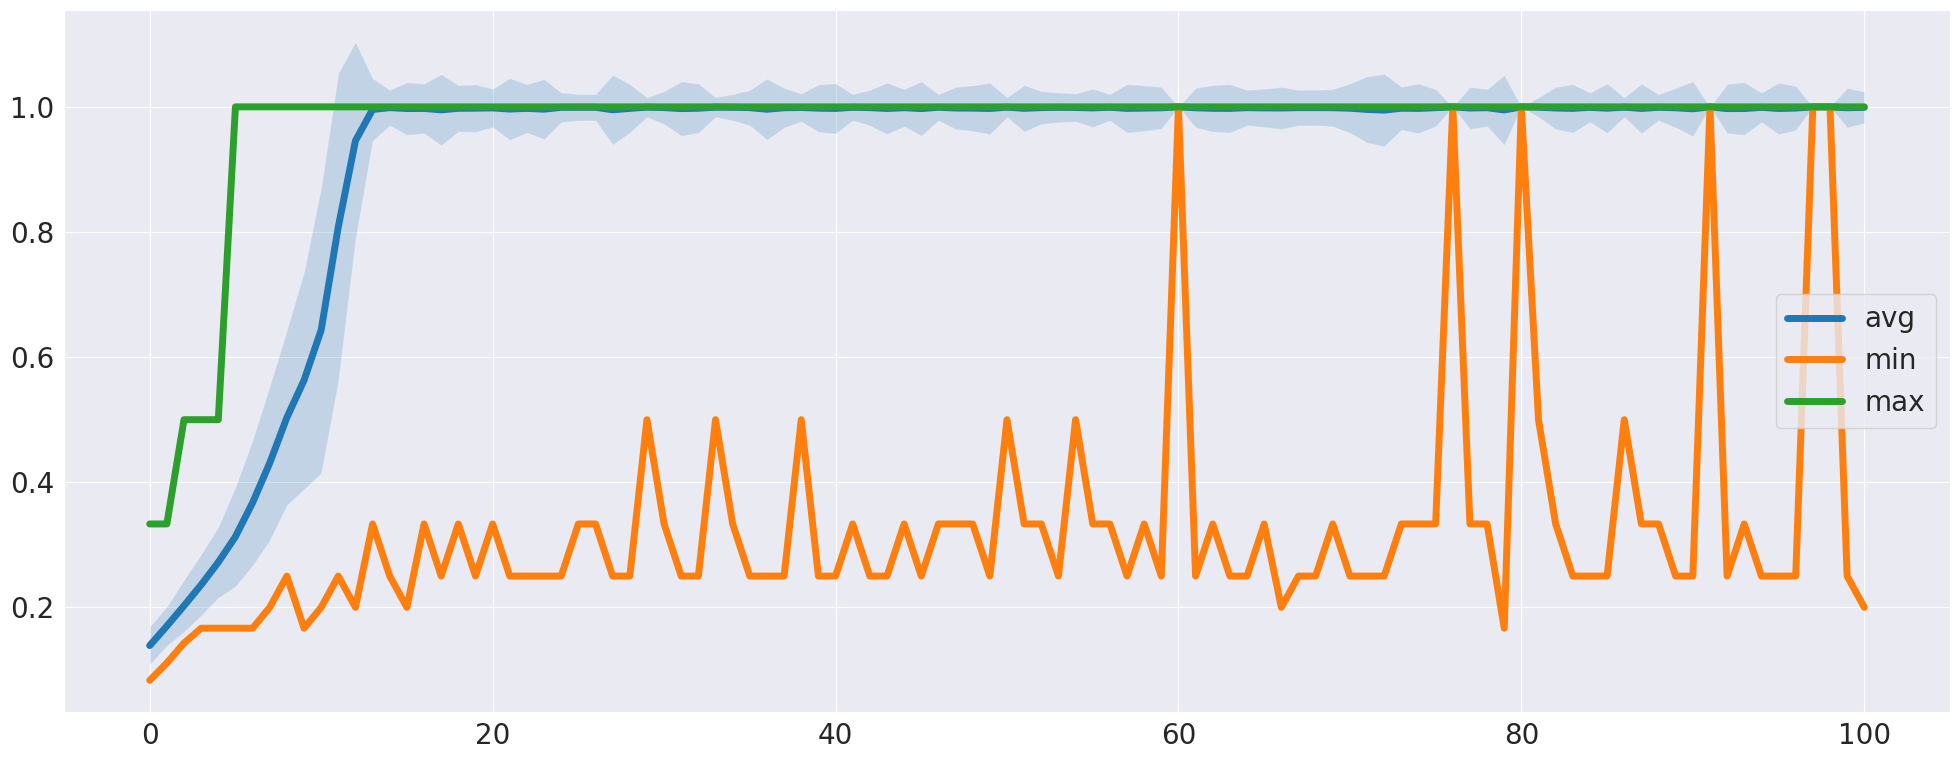

In [47]:
draw_log(log)

In [48]:
top_solution = [3, 5, 0, 4, 1, 7, 2, 6]
draw(top_solution)

+-----+-----+-----+-----+-----+-----+-----+-----+
|     |     |     |  X  |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |     |     |     |     |  X  |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|  X  |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |     |     |     |  X  |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |  X  |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |     |     |     |     |     |     |  X  |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |     |  X  |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
|     |     |     |     |     |     |  X  |     |
+-----+-----+-----+-----+-----+-----+-----+-----+
